For this 9th tutorial we will look at extreme levels spatially, and consider the importance of thresholds

In [1]:
# # <Yosmely Bermúdez> comments
# # Mount Google Drive locally
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# %cd gdrive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch\ Content\ Folder/W2D4\ -\ Climate\ Response\ -\ Extremes\ \&\ Variability/W2D4\ Tutorials

In [3]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install eigen
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install cmocean
# !pip install pandas
# !pip install cartopy
# !pip install scipy
# !pip install texttable

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import seaborn as sns
import cmocean.cm as cmo

import os

#import cftime
#import nc_time_axis

import numpy as np
import cartopy.crs as ccrs
from scipy import stats

In [5]:
import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

In [6]:
gev = stats.genextreme

In [7]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level
def estimate_return_level2(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level
def estimate_return_level3(quantile,loc,scale,shape):
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

The human body has physiological limits within which it can operate. When it is very hot, the body cools through sweat, that is evaporating water off the skin, which cools the body through "latent heat loss". This depends on the ability of the air to take up that water. This is why sweating is more efficient in dry heat, and why humid heat feels "hotter" - it is harder for the body to cool down.

Consequently, the combination of temperature and humidity imposes limits on the body to regulate its temperature. One metric of the combined effect is the "wet bulb temperature", the temperature a thermometer shows when wrapped in a wet sock. https://en.wikipedia.org/wiki/Wet-bulb_temperature

Here we use wet bulb temperature calculated from the MPI-ESM1-2-HR climate model run by the Max Planck Institute for Meteorology in Hamburg, Germany, for the historical period, and three future climate scenarios.
1. hist: The historical scenario, which typically covers the range of 1851-2014. The climate model uses what we know about volcanic eruptions, greenhouse gas emission etc.
The SSP scenarios cover 'possible climate futures' after 2014. Therefore they are predictions ("this is what we think will happen") but projections ("this is plausible given the assumptions"). The different scenarios make different such assumptions, largely about the speed and ambition which which humanity addresses global warming and reduces the emission of the greenhouse gases and other pollutants. 
2. SSP-126: This is an 'ambitious' climate scenario, with fast emission reductions, and consequently relatively low levels of global warming and climate impacts.
3. SSP-245: This is a 'medium' climate scenario that may be reasonably close to a "best guess" given the current policy trajectory and assuming political behavior continues like this.
4. SSP-585: This is the most extreme climate scenario considered by the IPCC, with strong economic growth fueled by greenhouse gas emissions. It has the strongest warming of all considered scenarios, and is thus often used as a 'worst-case scenario' (sometimes inappropriately). Many experts nowadays considere this scenario to be quite unlikely given the strong improvement in the ambition of mitigation policies in the last 10 years or so.

In pre-processing, the data was averaged over 7-days and then the annual maximum was computed. Therefore, for each grid point, the data describes the wet bulb temperature of the most extreme 7-day period in each year..

In [ ]:
import os, pooch

fname = 'WBGT_day_MPI-ESM1-2-HR_historical_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/69ms8/download"
    fname = pooch.retrieve(url, known_hash=None)

wetbulb_hist = xr.open_dataset(fname).WBGT

The data contains one entry per year. Because some years are leap years, the data processing step has given different days to the years. 
We find this undesirable for analysis. Therefore we resample the data (collect all the data points belonging to each year) and average them. 
Because there is only one data point per year, this does not modify the data, but only the time coordinate. 
Take from this to carefully inspect datasets that you open - often analysis workflows fail because such issues have been missed. 

In [9]:
wetbulb_hist = wetbulb_hist.resample(time='1Y').mean()

SHA256 hash of downloaded file: 45bf7ad1aae4e282ee1ef5302bcca7becee1999e768c41c20ff96ca5526485ff
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Let's load the data for the remaining scenarios:

In [26]:
# SSP-126
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp126_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/67b8m/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_126  = xr.open_dataset(fname).WBGT
wetbulb_126 = wetbulb_126.resample(time='1Y').mean()

# SSP-245
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp245_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/fsx5y/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_245 = xr.open_dataset(fname).WBGT
wetbulb_245 = wetbulb_245.resample(time='1Y').mean()

# SSP-585
fname = 'WBGT_day_MPI-ESM1-2-HR_ssp585_r1i1p1f1_raw_runmean7_yearmax.nc'
if not os.path.exists(fname):
    url = "https://osf.io/pr456/download"
    fname = pooch.retrieve(url, known_hash=None)
    
wetbulb_585 = xr.open_dataset(fname).WBGT
wetbulb_585 = wetbulb_585.resample(time='1Y').mean()

SHA256 hash of downloaded file: 08b78a22404166a9774787a9ed4b89e452f0d28e1b15feab7f315d92eb46fbcf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 67a645a5447553fcc89366e74e31da28ad8852ec9e82a1b3871fe3bc7fc043c8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 8aafc51015921ed0cb76c547937db91b2077577ee9f859001d4cfa26c613bc05
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Let's look at how the data is structured:

In [27]:
wetbulb_hist

<xarray.DataArray 'WBGT' (time: 64, lat: 192, lon: 384)>
array([[[-2.7235170e+01, -2.7209024e+01, -2.7091408e+01, ...,
         -2.7226376e+01, -2.7160492e+01, -2.7258596e+01],
        [-2.5137434e+01, -2.5155724e+01, -2.5227873e+01, ...,
         -2.5103416e+01, -2.5114450e+01, -2.5129984e+01],
        [-2.5405684e+01, -2.5478939e+01, -2.5416683e+01, ...,
         -2.5355572e+01, -2.5436531e+01, -2.5436386e+01],
        ...,
        [ 1.5202777e-01,  1.4101627e-01,  1.3330752e-01, ...,
          1.7247404e-01,  1.6777755e-01,  1.6128926e-01],
        [ 1.4682470e-01,  1.4339085e-01,  1.3746151e-01, ...,
          1.5303101e-01,  1.5185688e-01,  1.4891100e-01],
        [-6.8249358e-03, -7.0434422e-03, -8.7905107e-03, ...,
         -3.0952338e-03, -4.2250594e-03, -4.9193455e-03]],

       [[-2.6649139e+01, -2.6630531e+01, -2.6634752e+01, ...,
         -2.6691322e+01, -2.6607746e+01, -2.6625118e+01],
        [-2.5106850e+01, -2.5126314e+01, -2.5193607e+01, ...,
         -2.5092865e+01, -2.5098398e+01, -2.5103617e+01],
        [-2.5217392e+01, -2.5242710e+01, -2.5172596e+01, ...,
         -2.5080139e+01, -2.5190296e+01, -2.5223970e+01],
...
        [ 1.3378739e-01,  1.2870540e-01,  1.2770343e-01, ...,
          1.3989741e-01,  1.3784374e-01,  1.3685331e-01],
        [-4.5141011e-02, -4.6595134e-02, -5.1650975e-02, ...,
         -3.2980740e-02, -3.6983781e-02, -3.9977543e-02],
        [-1.8091998e-01, -1.8206993e-01, -1.8259056e-01, ...,
         -1.7845529e-01, -1.7992011e-01, -1.8005356e-01]],

       [[-2.5719893e+01, -2.5728792e+01, -2.5699797e+01, ...,
         -2.5871269e+01, -2.5829645e+01, -2.5588160e+01],
        [-2.3168945e+01, -2.3186224e+01, -2.3241858e+01, ...,
         -2.3076477e+01, -2.3144035e+01, -2.3166027e+01],
        [-2.2229086e+01, -2.2260471e+01, -2.2476068e+01, ...,
         -2.2073126e+01, -2.2129398e+01, -2.2191292e+01],
        ...,
        [-4.8862319e-02, -6.1266027e-02, -7.4026965e-02, ...,
         -1.7235180e-02, -2.6744476e-02, -3.6429971e-02],
        [-1.0998243e-01, -1.1364387e-01, -1.1661023e-01, ...,
         -9.9768467e-02, -1.0286019e-01, -1.0498482e-01],
        [-1.9145221e-01, -1.9040416e-01, -1.9016221e-01, ...,
         -1.9233751e-01, -1.9196975e-01, -1.9151381e-01]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1951-07-04 1952-07-02 ... 2014-07-01
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * lat      (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
Attributes:
    long_name:         Wet bulb globe temperature
    units:             1
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  96
    cell_methods:      time: maximum

There is one data point per year on a latitude-longitude grid. Let's compute the grid spacing in the longitude and latitude directions:

In [28]:
wetbulb_hist.lon.diff('lon').values.mean()

0.9375

In [29]:
wetbulb_hist.lat.diff('lat').values.mean()

0.9349133773038073

Each box is about 1 degree by 1 degree. 1 degree latitude is approximately 110 km, 1 degree longitude is 110 km at the equator, which decreases when moving towards the poles.

So at the equator we are looking at 100-by-100 km grid boxes, somewhat less in the mid-latitudes. 

Can you think of limitations this induces?

For illustration, let's extract the grid box that includes the city of New Delhi, India

In [30]:
wetbulb_hist_delhi = wetbulb_hist.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_126_delhi = wetbulb_126.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_245_delhi = wetbulb_245.sel(lon=77.21,lat=28.61,method='nearest')
wetbulb_585_delhi = wetbulb_585.sel(lon=77.21,lat=28.61,method='nearest')

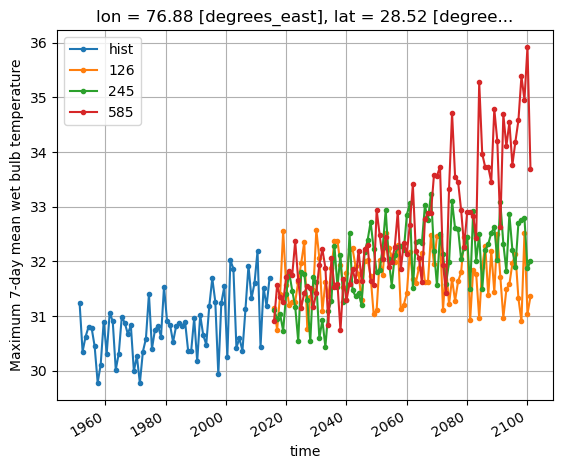

In [31]:
wetbulb_hist_delhi.plot.line('.-',label='hist')
wetbulb_126_delhi.plot.line('.-',label='126')
wetbulb_245_delhi.plot.line('.-',label='245')
wetbulb_585_delhi.plot.line('.-',label='585')

plt.legend()
plt.ylabel('Maximum 7-day mean wet bulb temperature')
plt.grid(True)

Note:
1. Trends are visible in the historical period
2. Clear differences between climate scenarios which become apparent at some point
3. Strong variability - each year is not necessarily warmer than the previous one

In [32]:
fit_hist, model_hist = ef.fit_return_levels_sdfc(wetbulb_hist_delhi.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

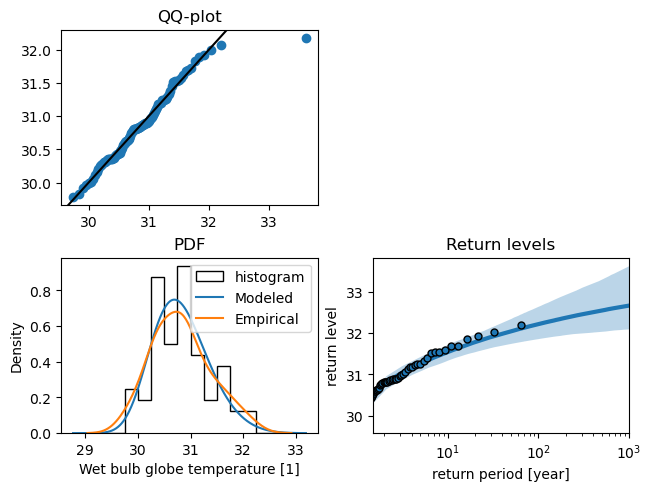

In [33]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, -fit_hist.xi.mean().values, loc=fit_hist.mu.mean().values, scale=fit_hist.sigma.mean().values), np.quantile(wetbulb_hist_delhi,x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_hist_delhi.min()-1, wetbulb_hist_delhi.max()+1, 1000)
wetbulb_hist_delhi.plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, -fit_hist.xi.mean().values, loc=fit_hist.mu.mean().values, scale=fit_hist.sigma.mean().values), label='Modeled')
sns.kdeplot(wetbulb_hist_delhi,ax=ax[2],label='Empirical')
ax[2].legend()

ef.plot_levels_from_obj(fit_hist,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [34]:
print('100-year return level: %.2f' % estimate_return_level(1-1/100,model_hist))

100-year return level: 32.23


Now let's compare with the last 50 years of the SSP-245 scenario, the middle scenario we looked at before. 2050-2100 are approximately stationary here (we will check this next!)

In [35]:
fit_245, model_245 = ef.fit_return_levels_sdfc(wetbulb_245_delhi.sel(time=slice('2051','2100')).values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

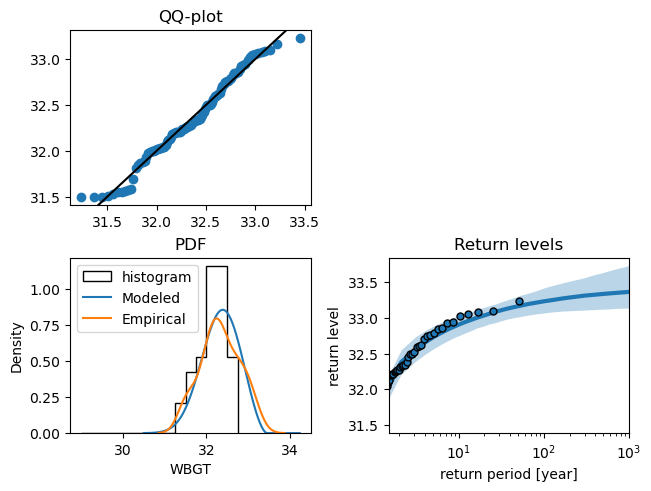

In [36]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(gev.ppf(x, -fit_245.xi.mean().values, loc=fit_245.mu.mean().values, scale=fit_245.sigma.mean().values), np.quantile(wetbulb_245_delhi.sel(time=slice('2051','2100')),x),'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(wetbulb_245_delhi.sel(time=slice('2051','2100')).min()-1, wetbulb_245_delhi.sel(time=slice('2051','2100')).max()+1, 1000)
wetbulb_245_delhi.sel(time=slice('2051','2100')).plot.hist(bins=np.arange(29,33,0.25),histtype='step',density=True,lw=1,color='k',ax=ax[2],label='histogram')
ax[2].plot(x,gev.pdf(x, -fit_245.xi.mean().values, loc=fit_245.mu.mean().values, scale=fit_245.sigma.mean().values), label='Modeled')
sns.kdeplot(wetbulb_245_delhi.sel(time=slice('2051','2100')),ax=ax[2],label='Empirical')
ax[2].legend()

ef.plot_levels_from_obj(fit_245,alpha=0.95,ax=ax[3])
ax[3].set_xlim(1.5,1000)
# ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

In [37]:
print('100-year return level: %.2f' % estimate_return_level(1-1/100,model_245))

100-year return level: 33.25


You can plot the two results (historical and SSP-245) together to compare

Now we assume the location parameter to be a function of time, and estimate the GEV distribution for the 4 scenarios:

In [38]:
law_ns_hist = sd.GEV()
law_ns_hist.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_126 = sd.GEV()
law_ns_126.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size))

law_ns_245 = sd.GEV()
law_ns_245.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size))

law_ns_585 = sd.GEV()
law_ns_585.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size))

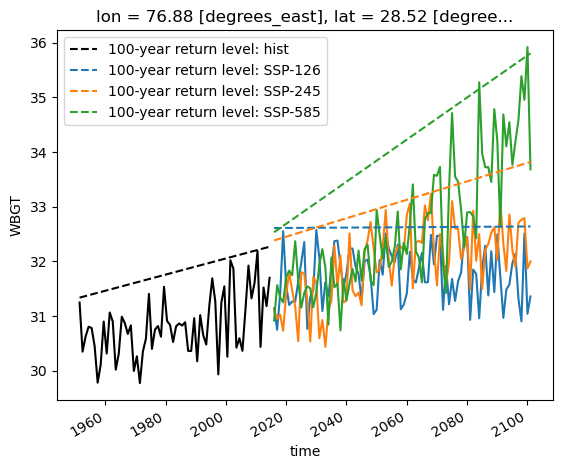

In [39]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level2(1-1/100,law_ns_hist),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level2(1-1/100,law_ns_126),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level2(1-1/100,law_ns_245),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level2(1-1/100,law_ns_585),'C2--',label='100-year return level: SSP-585')

plt.legend()

In [40]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info.optim_result.fun

In [41]:
compute_aic(model_245)

68.71474794440502

In [42]:
compute_aic(law_ns_245)

136.83928076564044

Now we assume both the location and the scale parameter to be a function of time, and estimate the GEV distribution for the 4 scenarios:

In [43]:
law_ns_hist_loc_scale = sd.GEV()
law_ns_hist_loc_scale.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size), c_scale = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126_loc_scale = sd.GEV()
law_ns_126_loc_scale.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_scale = np.arange(wetbulb_126_delhi.time.size))

law_ns_126_loc_scale = sd.GEV()
law_ns_126_loc_scale.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_scale = np.arange(wetbulb_126_delhi.time.size))

law_ns_245_loc_scale = sd.GEV()
law_ns_245_loc_scale.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size), c_scale = np.arange(wetbulb_245_delhi.time.size))

law_ns_585_loc_scale = sd.GEV()
law_ns_585_loc_scale.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size), c_scale = np.arange(wetbulb_585_delhi.time.size))

(29.453055235884126, 40.0)

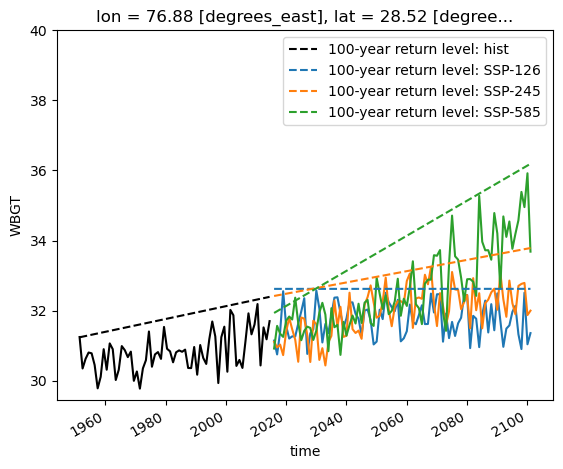

In [44]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level2(1-1/100,law_ns_hist_loc_scale),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level2(1-1/100,law_ns_126_loc_scale),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level2(1-1/100,law_ns_245_loc_scale),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level2(1-1/100,law_ns_585_loc_scale),'C2--',label='100-year return level: SSP-585')

plt.legend()
plt.ylim(None,40)

Now we assume both the location and the scale parameter to be a function of time, and estimate the GEV distribution for the 4 scenarios:

In [45]:
law_ns_hist_loc_shape = sd.GEV()
law_ns_hist_loc_shape.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size), c_shape = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126_loc_shape = sd.GEV()
law_ns_126_loc_shape.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_shape = np.arange(wetbulb_126_delhi.time.size))

law_ns_126_loc_shape = sd.GEV()
law_ns_126_loc_shape.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_shape = np.arange(wetbulb_126_delhi.time.size))

law_ns_245_loc_shape = sd.GEV()
law_ns_245_loc_shape.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size), c_shape = np.arange(wetbulb_245_delhi.time.size))

law_ns_585_loc_shape = sd.GEV()
law_ns_585_loc_shape.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size), c_shape = np.arange(wetbulb_585_delhi.time.size))

(29.450261717637844, 40.0)

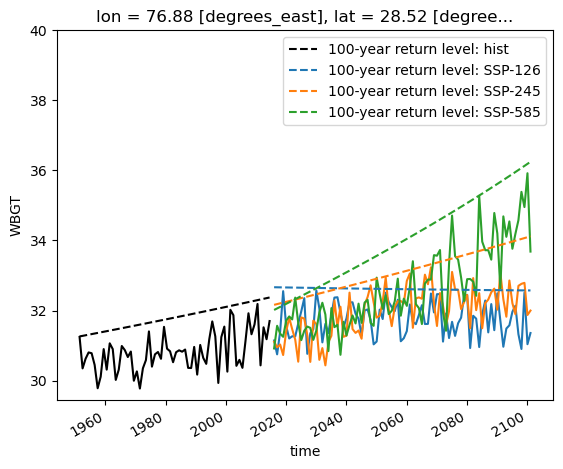

In [46]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level2(1-1/100,law_ns_hist_loc_shape),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level2(1-1/100,law_ns_126_loc_shape),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level2(1-1/100,law_ns_245_loc_shape),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level2(1-1/100,law_ns_585_loc_shape),'C2--',label='100-year return level: SSP-585')

plt.legend()
plt.ylim(None,40)

In [47]:
law_ns_hist_loc_scale_shape = sd.GEV()
law_ns_hist_loc_scale_shape.fit(wetbulb_hist_delhi.values, c_loc = np.arange(wetbulb_hist_delhi.time.size), c_scale = np.arange(wetbulb_hist_delhi.time.size), c_shape = np.arange(wetbulb_hist_delhi.time.size))

law_ns_126_loc_scale_shape = sd.GEV()
law_ns_126_loc_scale_shape.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_scale = np.arange(wetbulb_126_delhi.time.size), c_shape = np.arange(wetbulb_126_delhi.time.size))

law_ns_126_loc_scale_shape = sd.GEV()
law_ns_126_loc_scale_shape.fit(wetbulb_126_delhi.values, c_loc = np.arange(wetbulb_126_delhi.time.size), c_scale = np.arange(wetbulb_126_delhi.time.size), c_shape = np.arange(wetbulb_126_delhi.time.size))

law_ns_245_loc_scale_shape = sd.GEV()
law_ns_245_loc_scale_shape.fit(wetbulb_245_delhi.values, c_loc = np.arange(wetbulb_245_delhi.time.size), c_scale = np.arange(wetbulb_245_delhi.time.size), c_shape = np.arange(wetbulb_245_delhi.time.size))

law_ns_585_loc_scale_shape = sd.GEV()
law_ns_585_loc_scale_shape.fit(wetbulb_585_delhi.values, c_loc = np.arange(wetbulb_585_delhi.time.size), c_scale = np.arange(wetbulb_585_delhi.time.size), c_shape = np.arange(wetbulb_585_delhi.time.size))

(29.45464845539979, 40.0)

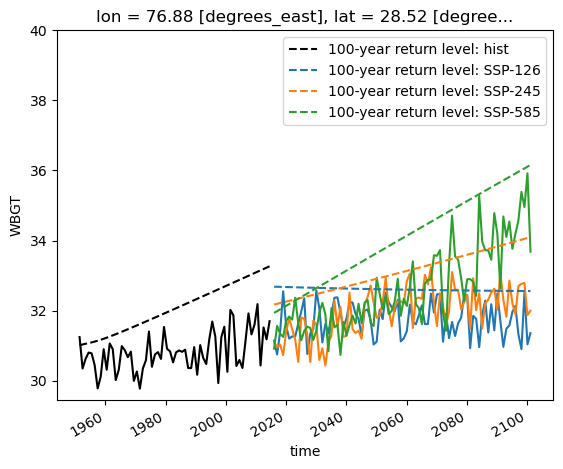

In [48]:
wetbulb_hist_delhi.plot.line(c='k')
wetbulb_126_delhi.plot.line(c='C0')
wetbulb_245_delhi.plot.line(c='C1')
wetbulb_585_delhi.plot.line(c='C2')

plt.plot(wetbulb_hist_delhi.time,estimate_return_level2(1-1/100,law_ns_hist_loc_scale_shape),'k--',label='100-year return level: hist')
plt.plot(wetbulb_126_delhi.time,estimate_return_level2(1-1/100,law_ns_126_loc_scale_shape),'C0--',label='100-year return level: SSP-126')
plt.plot(wetbulb_245_delhi.time,estimate_return_level2(1-1/100,law_ns_245_loc_scale_shape),'C1--',label='100-year return level: SSP-245')
plt.plot(wetbulb_585_delhi.time,estimate_return_level2(1-1/100,law_ns_585_loc_scale_shape),'C2--',label='100-year return level: SSP-585')

plt.legend()
plt.ylim(None,40)

In [49]:
compute_aic(law_ns_245)

136.83928076564044

In [50]:
aics = pd.DataFrame(columns=['hist','ssp126','ssp245','ssp585'],index=['loc','loc+scale','loc+shape','loc+scale+shape'])

aics['hist'] = compute_aic(law_ns_hist), compute_aic(law_ns_hist_loc_scale), compute_aic(law_ns_hist_loc_shape), compute_aic(law_ns_hist_loc_scale_shape)
aics['ssp126'] = compute_aic(law_ns_126), compute_aic(law_ns_126_loc_scale), compute_aic(law_ns_126_loc_shape), compute_aic(law_ns_126_loc_scale_shape)
aics['ssp245'] = compute_aic(law_ns_245), compute_aic(law_ns_245_loc_scale), compute_aic(law_ns_245_loc_shape), compute_aic(law_ns_245_loc_scale_shape)
aics['ssp585'] = compute_aic(law_ns_585), compute_aic(law_ns_585_loc_scale), compute_aic(law_ns_585_loc_shape), compute_aic(law_ns_585_loc_scale_shape)

In [51]:
aics.round(2)

,hist,ssp126,ssp245,ssp585
loc,96.58,123.99,136.84,179.08
loc+scale,96.19,125.95,138.82,167.71
loc+shape,98.06,125.74,138.64,175.91
loc+scale+shape,341.26,127.64,140.64,169.69


After looking at one location, we now make use of the spatial information:

This code fits the GEV distribution for each grid point. For the historical scenario this uses the entire time range, while for the scenarios we have chosen the period 2071-2100 - the last 30 years in the data. 

The takes some time to compute (around 9 minutes per dataset), so we have precomputed the data, and you just need to load it. Feel free to run (and/or modify) the computation when you have the time to wait. You may also include time-dependent parameters (as shown above) or do other modifications, for example focus on a specific region.

### Load pre-computed data:

In [54]:
# historical
fname = 'wbgt_hist_raw_runmean7_gev.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dakv3/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_hist = xr.open_dataset(fname)

# SSP-126
fname = 'wbgt_126_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/ef9pv/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_126 = xr.open_dataset(fname)

# SSP-245
fname = 'wbgt_245_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/j4hfc/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_245 = xr.open_dataset(fname)

# SSP-585
fname = 'wbgt_585_raw_runmean7_gev_2071-2100.nc'
if not os.path.exists(fname):
    url = "https://osf.io/y6edw/download"
    fname = pooch.retrieve(url, known_hash=None)
fit_sp_585 = xr.open_dataset(fname)

SHA256 hash of downloaded file: b98318842c15c16ee03fb23faca965abf18f78b862857f6109d6a6e073b86301
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 1e5cd5ef92336b23ad0c8d51c3cebfc87374d57ce375969d79243aff43c67b2f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 916063b8695dbf2e0c2cb630eeb6b36cb9c2b3cfe4912a45f2bc48837c11401c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Also load the area for each grid box - we will use this later to compute global averages:

In [62]:
fname = 'area_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/zqd86/download"
    fname = pooch.retrieve(url, known_hash=None)
area = xr.open_dataarray(fname)

fname = 'area_land_mpi.nc'
if not os.path.exists(fname):
    url = "https://osf.io/dxq98/download"
    fname = pooch.retrieve(url, known_hash=None)
area_land = xr.open_dataarray(fname).fillna(0.)

SHA256 hash of downloaded file: 8c7235af276325bf7683af3da90c106ac48324241a6ad137a83fcea8eaa2938d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 640613a7d608681804df67d6d480f09690da32de189184a774ff74773240c2aa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


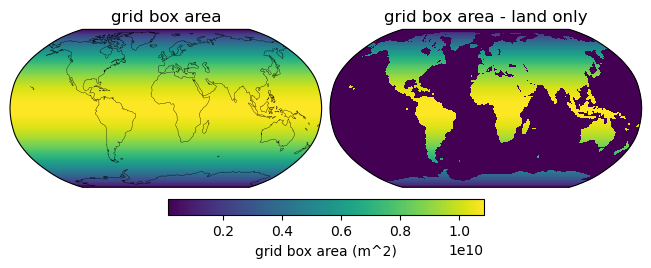

In [73]:
fig, ax = plt.subplots(1,2,sharex=True,sharey=True,constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))

p = area.plot(ax=ax[0],add_colorbar=False,transform=ccrs.PlateCarree())
area_land.plot(ax=ax[1],add_colorbar=False,transform=ccrs.PlateCarree())

ax[0].set_title('grid box area')
ax[1].set_title('grid box area - land only')

cbar = fig.colorbar(p,ax=ax,orientation='horizontal',shrink=0.5,pad=0.025,label='grid box area (m^2)')

ax[0].coastlines(lw=0.25)

### Expensive code that fits a GEV distribution to each grid point

In [ ]:
# fit_sp_hist = ef.fit_return_levels_sdfc_2d(wetbulb_hist.rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_hist.to_netcdf('wbgt_hist_raw_runmean7_gev.nc')
# fit_sp_126 = ef.fit_return_levels_sdfc_2d(wetbulb_126.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_126.to_netcdf('wbgt_126_raw_runmean7_gev_2071-2100.nc')
# fit_sp_245 = ef.fit_return_levels_sdfc_2d(wetbulb_245.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_245.to_netcdf('wbgt_245_raw_runmean7_gev_2071-2100.nc')
# fit_sp_585 = ef.fit_return_levels_sdfc_2d(wetbulb_585.sel(time=slice('2071','2100')).rename({'lon':'longitude','lat':'latitude'}),times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=0,full=True)
# fit_sp_585.to_netcdf('wbgt_585_raw_runmean7_gev_2071-2100.nc')

In the plot below the colorbar begins at 28 degrees, which is around the level experience in the heatwaves in 2003 in Europe andn 2010 in Russia

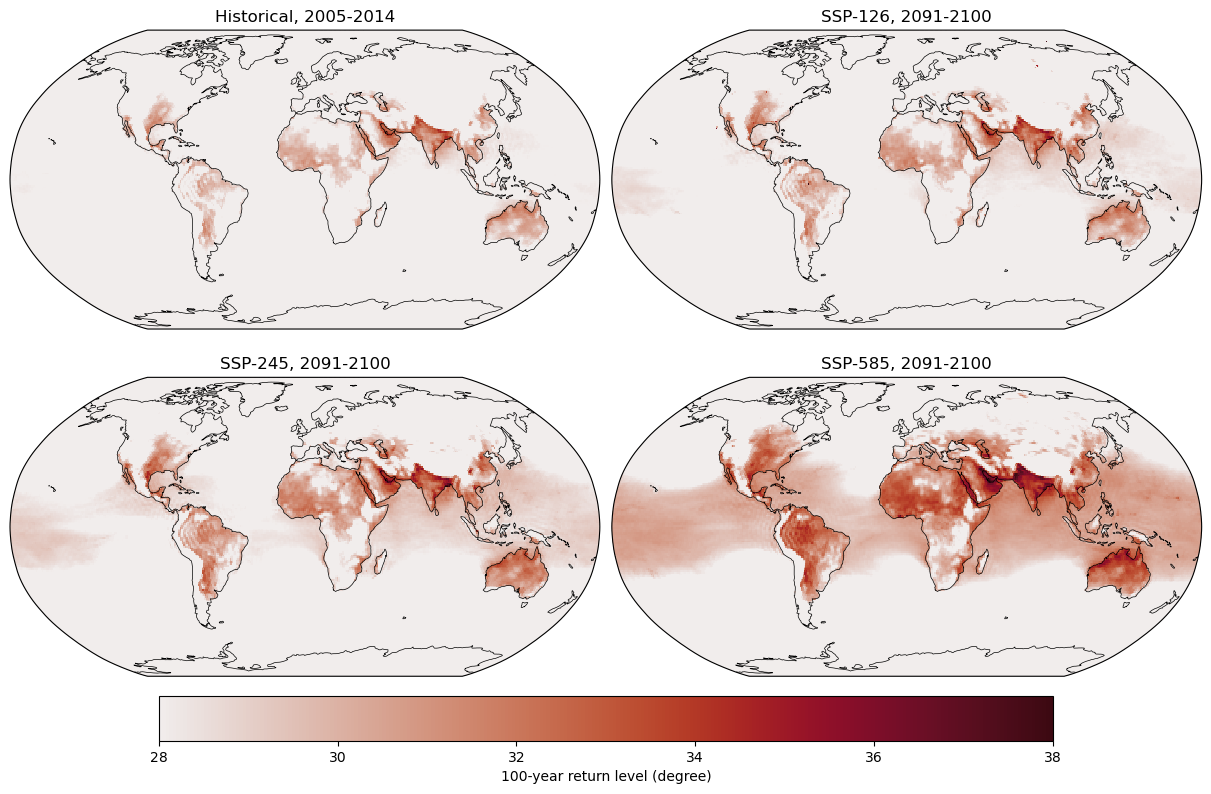

In [57]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=28,
    vmax=38,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = fit_sp_hist['return level'].sel({'return period':100},method='nearest').plot(ax=ax[0],**kwargs)
fit_sp_126['return level'].sel({'return period':100},method='nearest').plot(ax=ax[1],**kwargs)
fit_sp_245['return level'].sel({'return period':100},method='nearest').plot(ax=ax[2],**kwargs)
fit_sp_585['return level'].sel({'return period':100},method='nearest').plot(ax=ax[3],**kwargs)

cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='100-year return level (degree)')

ax[0].set_title('Historical, 2005-2014')
ax[1].set_title('SSP-126, 2091-2100')
ax[2].set_title('SSP-245, 2091-2100')
ax[3].set_title('SSP-585, 2091-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

Let's look at the most intense heatwave in the last 10 years (2091-2100), and the most intense in 2005-2014

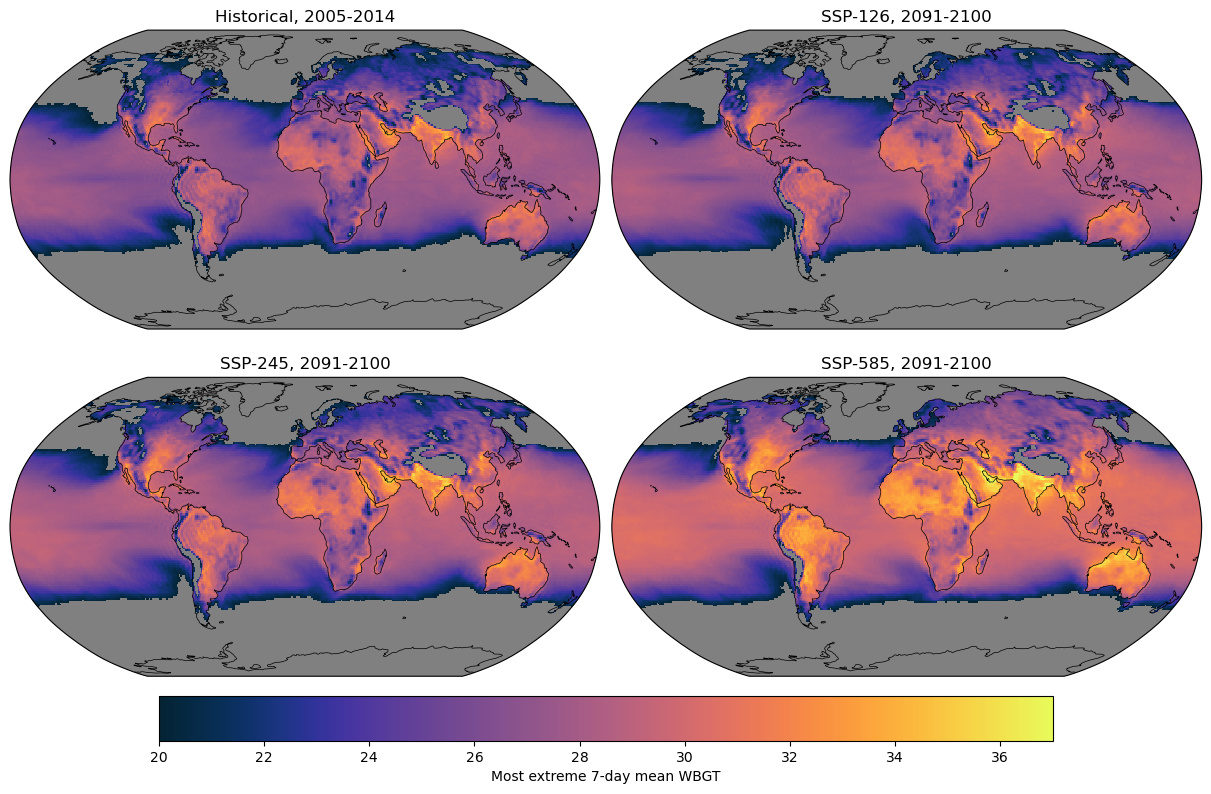

In [58]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=20,
    vmax=37,
    cmap=cmo.thermal,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = wetbulb_hist.sel(time=slice('2005','2014')).max('time').where(lambda x:x>20).plot(ax=ax[0],**kwargs)
wetbulb_126.sel(time=slice('2091','2100')).max('time').where(lambda x:x>20).plot(ax=ax[1],**kwargs)
wetbulb_245.sel(time=slice('2091','2100')).max('time').where(lambda x:x>20).plot(ax=ax[2],**kwargs)
wetbulb_585.sel(time=slice('2091','2100')).max('time').where(lambda x:x>20).plot(ax=ax[3],**kwargs)

cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='Most extreme 7-day mean WBGT')

ax[0].set_title('Historical, 2005-2014')
ax[1].set_title('SSP-126, 2091-2100')
ax[2].set_title('SSP-245, 2091-2100')
ax[3].set_title('SSP-585, 2091-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

Text(0.5, 0.98, 'Shaded regions for most extreme heatwave is > 31 WBGT')

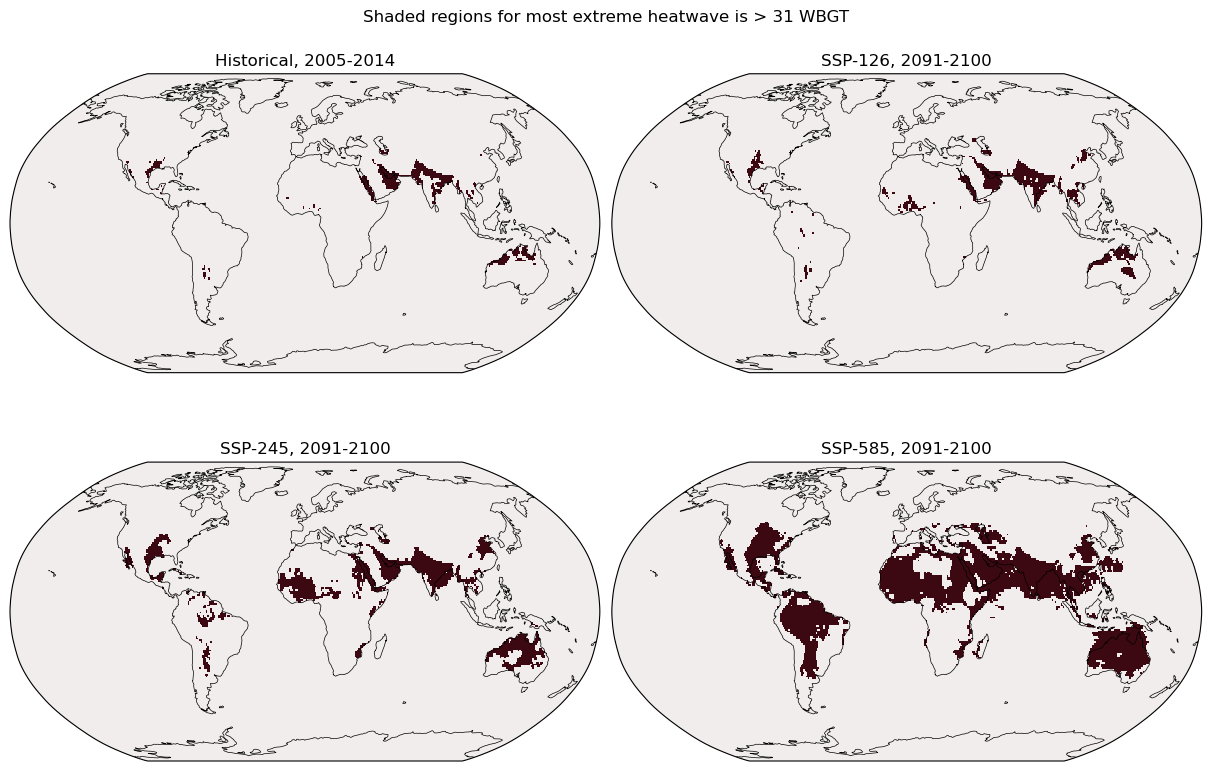

In [59]:
fig, axs = plt.subplots(2,2,constrained_layout=True,figsize=(12,8),subplot_kw=dict(projection=ccrs.Robinson()))
ax = axs.flatten()

kwargs = dict(
    vmin=0,
    # vmin=20,
    # vmax=37,
    cmap=cmo.amp,
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

p = (wetbulb_hist.sel(time=slice('2005','2014')).max('time')>31).plot(ax=ax[0],**kwargs)
(wetbulb_126.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[1],**kwargs)
(wetbulb_245.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[2],**kwargs)
(wetbulb_585.sel(time=slice('2091','2100')).max('time')>31).plot(ax=ax[3],**kwargs)

# cbar = fig.colorbar(p,ax=ax,pad=0.025,orientation='horizontal',shrink=0.75,label='Most extreme 7-day mean WBGT')

ax[0].set_title('Historical, 2005-2014')
ax[1].set_title('SSP-126, 2091-2100')
ax[2].set_title('SSP-245, 2091-2100')
ax[3].set_title('SSP-585, 2091-2100')

[axi.set_facecolor('grey') for axi in ax]
[axi.coastlines(lw=0.5) for axi in ax]

fig.suptitle('Shaded regions for most extreme heatwave is > 31 WBGT')

Now we want to look at how the fraction of the Earth's land surface that experiences such extreme heatwaves changes over time. For this we need the area of each grid box which have been pre-computed. 

We then take the temporal-spatial data and assign it the value "1" if it exceeds the threshold and the value "0" if it does not. Performing area-weighted averaging over the whole world gives the fraction of land area that experiences a heat wave above the threshold in each year.

Let's compute this for a few different temperature threshold, we suggest 31, 28 and 33 degrees. 

Look at the time evolution - what do you see?

Text(0.5, 1.0, 'Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

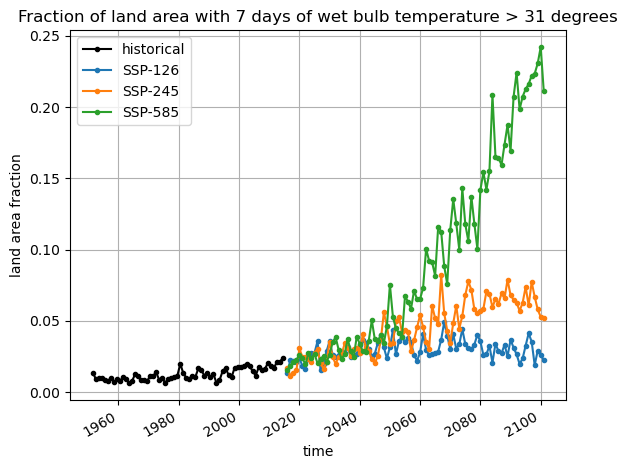

In [74]:
((wetbulb_hist>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('k.-',label='historical')
((wetbulb_126>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-126')
((wetbulb_245>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-245')
((wetbulb_585>31)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-585')

plt.grid(True)

plt.legend()
plt.ylabel('land area fraction')
plt.title('Fraction of land area with 7 days of wet bulb temperature > 31 degrees')

Text(0.5, 1.0, 'Fraction of land area with 7 days of wet bulb temperature > 28 degrees')

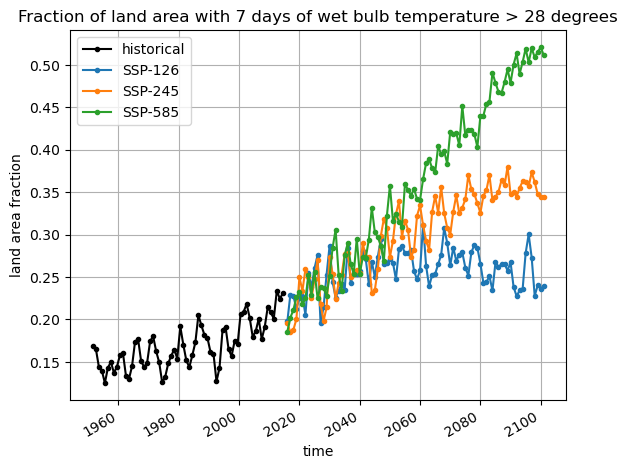

In [75]:
((wetbulb_hist>28)*1).weighted(area_land).mean(['lon','lat']).plot.line('k.-',label='historical')
((wetbulb_126>28)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-126')
((wetbulb_245>28)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-245')
((wetbulb_585>28)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-585')

plt.grid(True)

plt.legend()
plt.ylabel('land area fraction')
plt.title('Fraction of land area with 7 days of wet bulb temperature > 28 degrees')

Text(0.5, 1.0, 'Fraction of land area with 7 days of wet bulb temperature > 33 degrees')

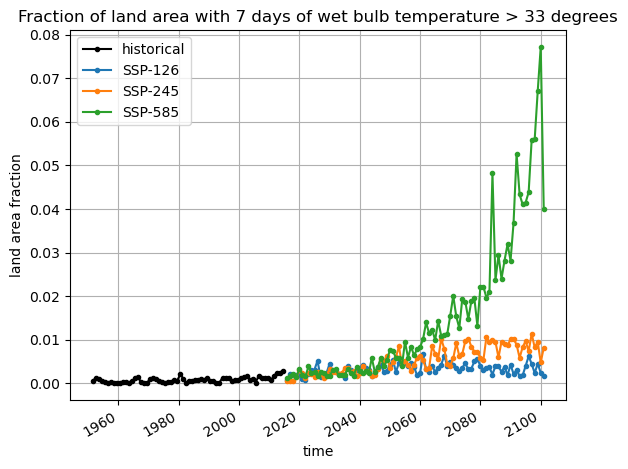

In [76]:
((wetbulb_hist>33)*1).weighted(area_land).mean(['lon','lat']).plot.line('k.-',label='historical')
((wetbulb_126>33)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-126')
((wetbulb_245>33)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-245')
((wetbulb_585>33)*1).weighted(area_land).mean(['lon','lat']).plot.line('.-',label='SSP-585')

plt.grid(True)

plt.legend()
plt.ylabel('land area fraction')
plt.title('Fraction of land area with 7 days of wet bulb temperature > 33 degrees')

In [77]:
(pd.Series(
    index=['historical','SSP-126','SSP-245','SSP-585'],
    data=[
    ((wetbulb_hist>28)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_126>28)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_245>28)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_585>28)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values
    ]
).astype(float) * 100).round(2)

historical    20.68
SSP-126       24.93
SSP-245       35.53
SSP-585       51.05
dtype: float64

In [78]:
(pd.Series(
    index=['historical','SSP-126','SSP-245','SSP-585'],
    data=[
    ((wetbulb_hist>33)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_126>33)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_245>33)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values,
    ((wetbulb_585>33)*1).weighted(area_land).mean(['lon','lat']).isel(time=slice(-10,None)).mean().values
    ]
).astype(float) * 100).round(2)

historical    0.15
SSP-126       0.32
SSP-245       0.82
SSP-585       5.18
dtype: float64

We see that a smaller fraction of the Earth experiences more extreme heat waves - as expected.

However, the difference between the scenarios becomes larger for more extreme events:
The area fraction that experiences heat waves above 28 degrees increases by 51.05 / 20.68 = 2.46 times between historical and SSP-585 scenarios, but for heat waves above 33 degrees it is 5.18 / 0.15 = 34.53 times!